In [ ]:
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd # this module is useful to work with tabular data
import random # this module will be used to select random samples from a collection
import os # this module will be used just to create directories in the local filesystem
from tqdm import tqdm # this module is useful to plot progress bars

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import nn

In [ ]:
### Download the data and create dataset
data_dir = 'dataset'
# With these commands the train and test datasets, respectively, are downloaded 
# automatically and stored in the local "data_dir" directory.
train_dataset = torchvision.datasets.FashionMNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.FashionMNIST(data_dir, train=False, download=True)

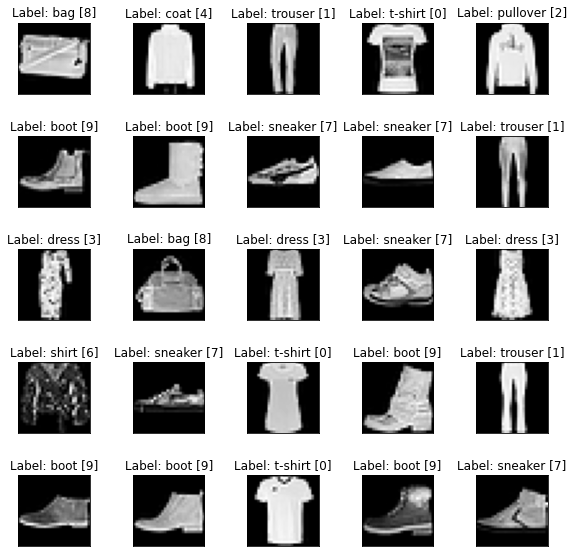

In [ ]:
### Plot some sample
label_names=['t-shirt','trouser','pullover','dress','coat','sandal','shirt',
             'sneaker','bag','boot']
fig, axs = plt.subplots(5, 5, figsize=(8,8))
for ax in axs.flatten():
    # random.choice allows to randomly sample from a list-like object (basically anything that can be accessed with an index, like our dataset)
    img, label = random.choice(train_dataset)
    ax.imshow(np.array(img), cmap='gist_gray')
    ax.set_title(f'Label: {label_names[label]} [{label}]')
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()

In [ ]:
# In this case the train_transform and test_transform are the same, 
# but we keep them separate for potential future updates
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(572)
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(572)
])


In [ ]:
# Set the train transform
train_dataset.transform = train_transform
# Set the test transform
test_dataset.transform = test_transform

In [ ]:
# check what is going on AFTER the transformation is in place!
print(train_dataset)
print(train_dataset[0])
print(train_dataset[0][0])
print(train_dataset[0][1])

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: dataset
    Split: Train
(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]]), 9)
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
9


In [ ]:
### Define train dataloader
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
### Define test dataloader
test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=False)


batch_data, batch_labels = next(iter(train_dataloader))
print(f"TRAIN BATCH SHAPE")
print(f"\t Data: {batch_data.shape}")
print(f"\t Labels: {batch_labels.shape}")

batch_data, batch_labels = next(iter(test_dataloader))
print(f"TEST BATCH SHAPE")
print(f"\t Data: {batch_data.shape}")
print(f"\t Labels: {batch_labels.shape}")

TRAIN BATCH SHAPE
	 Data: torch.Size([256, 1, 572, 572])
	 Labels: torch.Size([256])
TEST BATCH SHAPE
	 Data: torch.Size([256, 1, 572, 572])
	 Labels: torch.Size([256])


In [ ]:
from torch import nn


class ConvBlock(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        return x


In [ ]:
# test conv block
enc_block = ConvBlock(1, 64)
x         = torch.randn(1, 1, 572, 572)
enc_block(x).shape

torch.Size([1, 64, 568, 568])

In [ ]:
from torch import nn


class Encoder(nn.Module):

    def __init__(self, channels=(1,64,128,256,512,1024)):
      super().__init__()
      self.encBlock = nn.ModuleList([ConvBlock(channels[i], channels[i+1]) for i in range(len(channels)-1)]) # stack of conv block
      self.pool = nn.MaxPool2d(2)

    def forward(self, x):
        convBlockOutput = []
        for block in self.encBlock:
          x = block(x)
          convBlockOutput.append(x)
          x = self.pool(x)
        return convBlockOutput


In [ ]:
# test encoder
encoder = Encoder()
z = torch.randn(1, 1, 572, 572)
fltrs = encoder(z)
for ftr in fltrs:
  print(ftr.shape)


torch.Size([1, 64, 568, 568])
torch.Size([1, 128, 280, 280])
torch.Size([1, 256, 136, 136])
torch.Size([1, 512, 64, 64])
torch.Size([1, 1024, 28, 28])


In [ ]:
from torch import nn


class Decoder(nn.Module):
    def __init__(self, channels=(1024,512,256,128,64)):
        super().__init__()
        self.channels = channels
        self.upconvs = nn.ModuleList([nn.ConvTranspose2d(channels[i], channels[i+1], 2, 2) for i in range(len(channels)-1)]) # stack up conv layer
        self.decBlock = nn.ModuleList([ConvBlock(channels[i], channels[i+1]) for i in range(len(channels)-1)]) # stack of conv layer

    def forward(self, x, encoder_features):
      for i in range(len(self.channels)-1):
        x = self.upconvs[i](x)
        enc_ftrs = self.crop(encoder_features[i], x)
        x = torch.cat([x, enc_ftrs], dim=1)
        x = self.decBlock[i](x)
      return x

    def crop(self, enc_ftrs, x):
      (_, _, H, W) = x.shape
      enc_ftrs = torchvision.transforms.CenterCrop([H,W])(enc_ftrs)
      return enc_ftrs

In [ ]:
decoder = Decoder()
x = torch.randn(1, 1024, 28, 28)
decoder(x, fltrs[::-1][1:]).shape

torch.Size([1, 64, 388, 388])

In [ ]:
from torch import nn

class UNet(nn.Module):
    def __init__(self, encoder_channels=(1,64,128,256,512,1024), decoder_channels=(1024,512,256,128,64), num_class=1, retain_dim=False, output_size=(28, 28)):
        super().__init__()
        self.encoder = Encoder(encoder_channels)
        self.decoder = Decoder(decoder_channels)
        self.conv = nn.Conv2d(decoder_channels[-1], num_class, 1)
        self.retain_dim = retain_dim
        self.output_size = output_size

    def forward(self, x):
      encoder_features = self.encoder(x)
      output = self.decoder(encoder_features[::-1][0], encoder_features[::-1][1:])
      output = self.conv(output)
      if self.retain_dim:
        output = nn.functional.interpolate(output, self.output_size)
      return output
      
        

In [ ]:
unet = UNet()
x = torch.randn(1, 1, 572, 572)
unet(x).shape

torch.Size([1, 1, 388, 388])

In [ ]:
### Some examples

# Take an input image (remember to add the batch dimension)
img, _ = test_dataset[0]
img = img.unsqueeze(0) # Add the batch dimension in the first axis

#resize_img = torchvision.transforms.functional.resize(img,size=[572,572])
print('image shape:', img.shape)

#proc_img = unet(resize_img)
#print(proc_img.shape)

image shape: torch.Size([1, 1, 572, 572])


In [ ]:
loss_fn = torch.nn.MSELoss()

lr = 5e-4

params_to_optimize = [{'params': unet.parameters()}]

optim = torch.optim.Adam(params=params_to_optimize, lr=lr, weight_decay=1e-5)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Selected device: ", device)

unet.to(device)

Selected device:  cpu


UNet(
  (encoder): Encoder(
    (encBlock): ModuleList(
      (0): ConvBlock(
        (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU()
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): ConvBlock(
        (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU()
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (2): ConvBlock(
        (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
        (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [ ]:
### Training function
def train_epoch(unet, device, dataloader, loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    unet.train()
    losses = []
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning),  # with "_" we just ignore the labels (the second element of the dataloader tuple)
    for image_batch, _ in dataloader:
      image_batch = image_batch.to(device)
      decoded_data = unet(image_batch)

      loss = loss_fn(decoded_data, image_batch)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      losses.append(loss.detach().cpu().numpy())
      
    losses = np.mean(losses)
    return losses

In [ ]:
### Testing function
def test_epoch(unet, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    unet.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            # Decode data
            decoded_data = unet(image_batch)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

In [ ]:
### Training cycle
num_epochs = 10
unet = UNet()
for epoch in range(num_epochs):
    print('EPOCH %d/%d' % (epoch + 1, num_epochs))
    ### Training (use the training function)
    train_loss = train_epoch(
        unet=unet, 
        device=device, 
        dataloader=train_dataloader, 
        loss_fn=loss_fn, 
        optimizer=optim)
    print(f'TRAIN - EPOCH {epoch+1}/{num_epochs} - loss: {train_loss}')

    ### Validation  (use the testing function)
    val_loss = test_epoch(
        unet=unet, 
        device=device, 
        dataloader=test_dataloader, 
        loss_fn=loss_fn)
    # Print Validationloss
    print(f'VALIDATION - EPOCH {epoch+1}/{num_epochs} - loss: {val_loss}\n')

    # Save network parameters
    torch.save(unet.state_dict(), 'unet_params.pth')

    # NOTE: Remember to save also the parameters of the optimizer if you want to restore and continue the training

EPOCH 1/10
